# Proyek Klasifikasi Gambar: Flower Classification | 10 Classes |
- **Nama:** Stevi Aprilianti Cahyani
- **Email:** steviaprilia7@gmail.com
- **ID Dicoding:** apriliaastevi

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [2]:
# Utilitas Umum: untuk manajemen file, folder, dan proses randomisasi
import os                          # Interaksi dengan sistem file
import shutil                      # Penyalinan dan pemindahan file/folder
import zipfile                     # Mengekstrak file zip
import random                      # Randomisasi (misalnya pemilihan gambar acak)

# Analisis Data & Visualisasi: untuk eksplorasi, analisis, dan visualisasi data
import numpy as np                 # Operasi numerik dan array
import pandas as pd                # Manipulasi data dalam bentuk tabel
import matplotlib.pyplot as plt    # Visualisasi grafik
import seaborn as sns              # Visualisasi statistik (misalnya heatmap)
from PIL import Image              # Membuka dan memproses gambar

# Scikit-learn: untuk evaluasi model dan pembagian data
from sklearn.model_selection import train_test_split                  # Membagi dataset
from sklearn.metrics import confusion_matrix, classification_report   # Evaluasi performa klasifikasi

# TensorFlow & Keras: untuk membangun dan melatih model deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential                      # Membuat model sequential
from tensorflow.keras.applications import MobileNetV2                 # Model pretrained MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers.schedules import ExponentialDecay    # Learning rate decay
from tensorflow.keras.preprocessing.image import ImageDataGenerator   # Augmentasi dan preprocessing gambar
from tensorflow.keras.regularizers import l2                          # Regularisasi L2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback  # Callback saat training
from tensorflow.keras.preprocessing import image                      # Untuk proses gambar saat inference

# TensorFlow.js: untuk konversi model ke format yang bisa dijalankan di browser
import tensorflowjs as tfjs

# Google Colab: untuk upload/download file saat di Colab
from google.colab import files


In [3]:
# Menampilkan versi TensorFlow dan TensorFlow.js yang digunakan
print(f"TensorFlow version     : {tf.__version__}")
print(f"TensorFlow.js version : {tfjs.__version__}")

TensorFlow version     : 2.18.0
TensorFlow.js version : 4.22.0


## Data Preparation

### Data Loading

In [4]:
# Mengunggah file dari lokal ke Colab (digunakan untuk mengupload kaggle.json)
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"steviapriliaa","key":"075a9272e635b260735af869dcdb6ea9"}'}

In [5]:
# Membuat folder konfigurasi Kaggle (jika belum ada)
!mkdir -p ~/.kaggle

# Memindahkan file API key kaggle.json ke direktori konfigurasi
!cp kaggle.json ~/.kaggle/

# Mengatur permission file agar hanya dapat diakses oleh user
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Mengunduh dataset dari Kaggle menggunakan API
!kaggle datasets download -d utkarshsaxenadn/flower-classification-5-classes-roselilyetc

Dataset URL: https://www.kaggle.com/datasets/utkarshsaxenadn/flower-classification-5-classes-roselilyetc
License(s): CC0-1.0


In [7]:
# Mengekstrak file zip dataset yang sudah didownload dari Kaggle
with zipfile.ZipFile("/content/flower-classification-5-classes-roselilyetc.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/flower-classification/")

In [8]:
# Menghapus file dan folder yang tidak diperlukan untuk menghemat ruang penyimpanan
# Menghapus folder 'TFRecords' yang berisi data TensorFlow yang tidak digunakan
shutil.rmtree('/content/flower-classification/Flower Classification V2/V2/TFRecords', ignore_errors=True)

# Menghapus folder utama 'Flower Classification' yang sudah tidak dibutuhkan
shutil.rmtree('/content/flower-classification/Flower Classification', ignore_errors=True)

# Menampilkan pesan konfirmasi bahwa folder yang tidak diperlukan telah berhasil dihapus
print("Folder yang tidak digunakan berhasil dihapus.")

Folder yang tidak digunakan berhasil dihapus.


In [9]:
# Melihat daftar label kelas pada dataset
# Membaca label kelas pada dataset
print(os.listdir("/content/flower-classification/Flower Classification V2/V2/Training Data"))

['Rose', 'Lily', 'Sunflower', 'Poppy', 'Daisy', 'Iris', 'Marigold', 'Lavender', 'Aster', 'Orchid']


## Menggabungkan Data Train, Data Test dan Data Validasi ke Direktori yang Sama

In [10]:
# Direktori awal untuk data pelatihan (train), pengujian (test), dan validasi (validation)
train_direct = "/content/flower-classification/Flower Classification V2/V2/Training Data"
test_direct = "/content/flower-classification/Flower Classification V2/V2/Testing Data"
validation_direct = "/content/flower-classification/Flower Classification V2/V2/Validation Data"

# Direktori baru untuk menyimpan dataset gabungan dari train, test, dan validation
combine_direct = "/content/flower-classification/combine-dataset"

# Membuat direktori baru untuk dataset gabungan jika belum ada
os.makedirs(combine_direct, exist_ok=True)

# Menyalin data dari direktori pelatihan (train) ke dalam combine_direct
for category in os.listdir(train_direct):
    category_dir = os.path.join(train_direct, category)  # Path kategori di direktori pelatihan
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combine_direct, category), dirs_exist_ok=True)

# Menyalin data dari direktori pengujian (test) ke dalam combine_direct
for category in os.listdir(test_direct):
    category_dir = os.path.join(test_direct, category)  # Path kategori di direktori pengujian
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combine_direct, category), dirs_exist_ok=True)

# Menyalin data dari direktori validasi (validation) ke dalam combine_direct
for category in os.listdir(validation_direct):
    category_dir = os.path.join(validation_direct, category)  # Path kategori di direktori validasi
    if os.path.isdir(category_dir):
       shutil.copytree(category_dir, os.path.join(combine_direct, category), dirs_exist_ok=True)

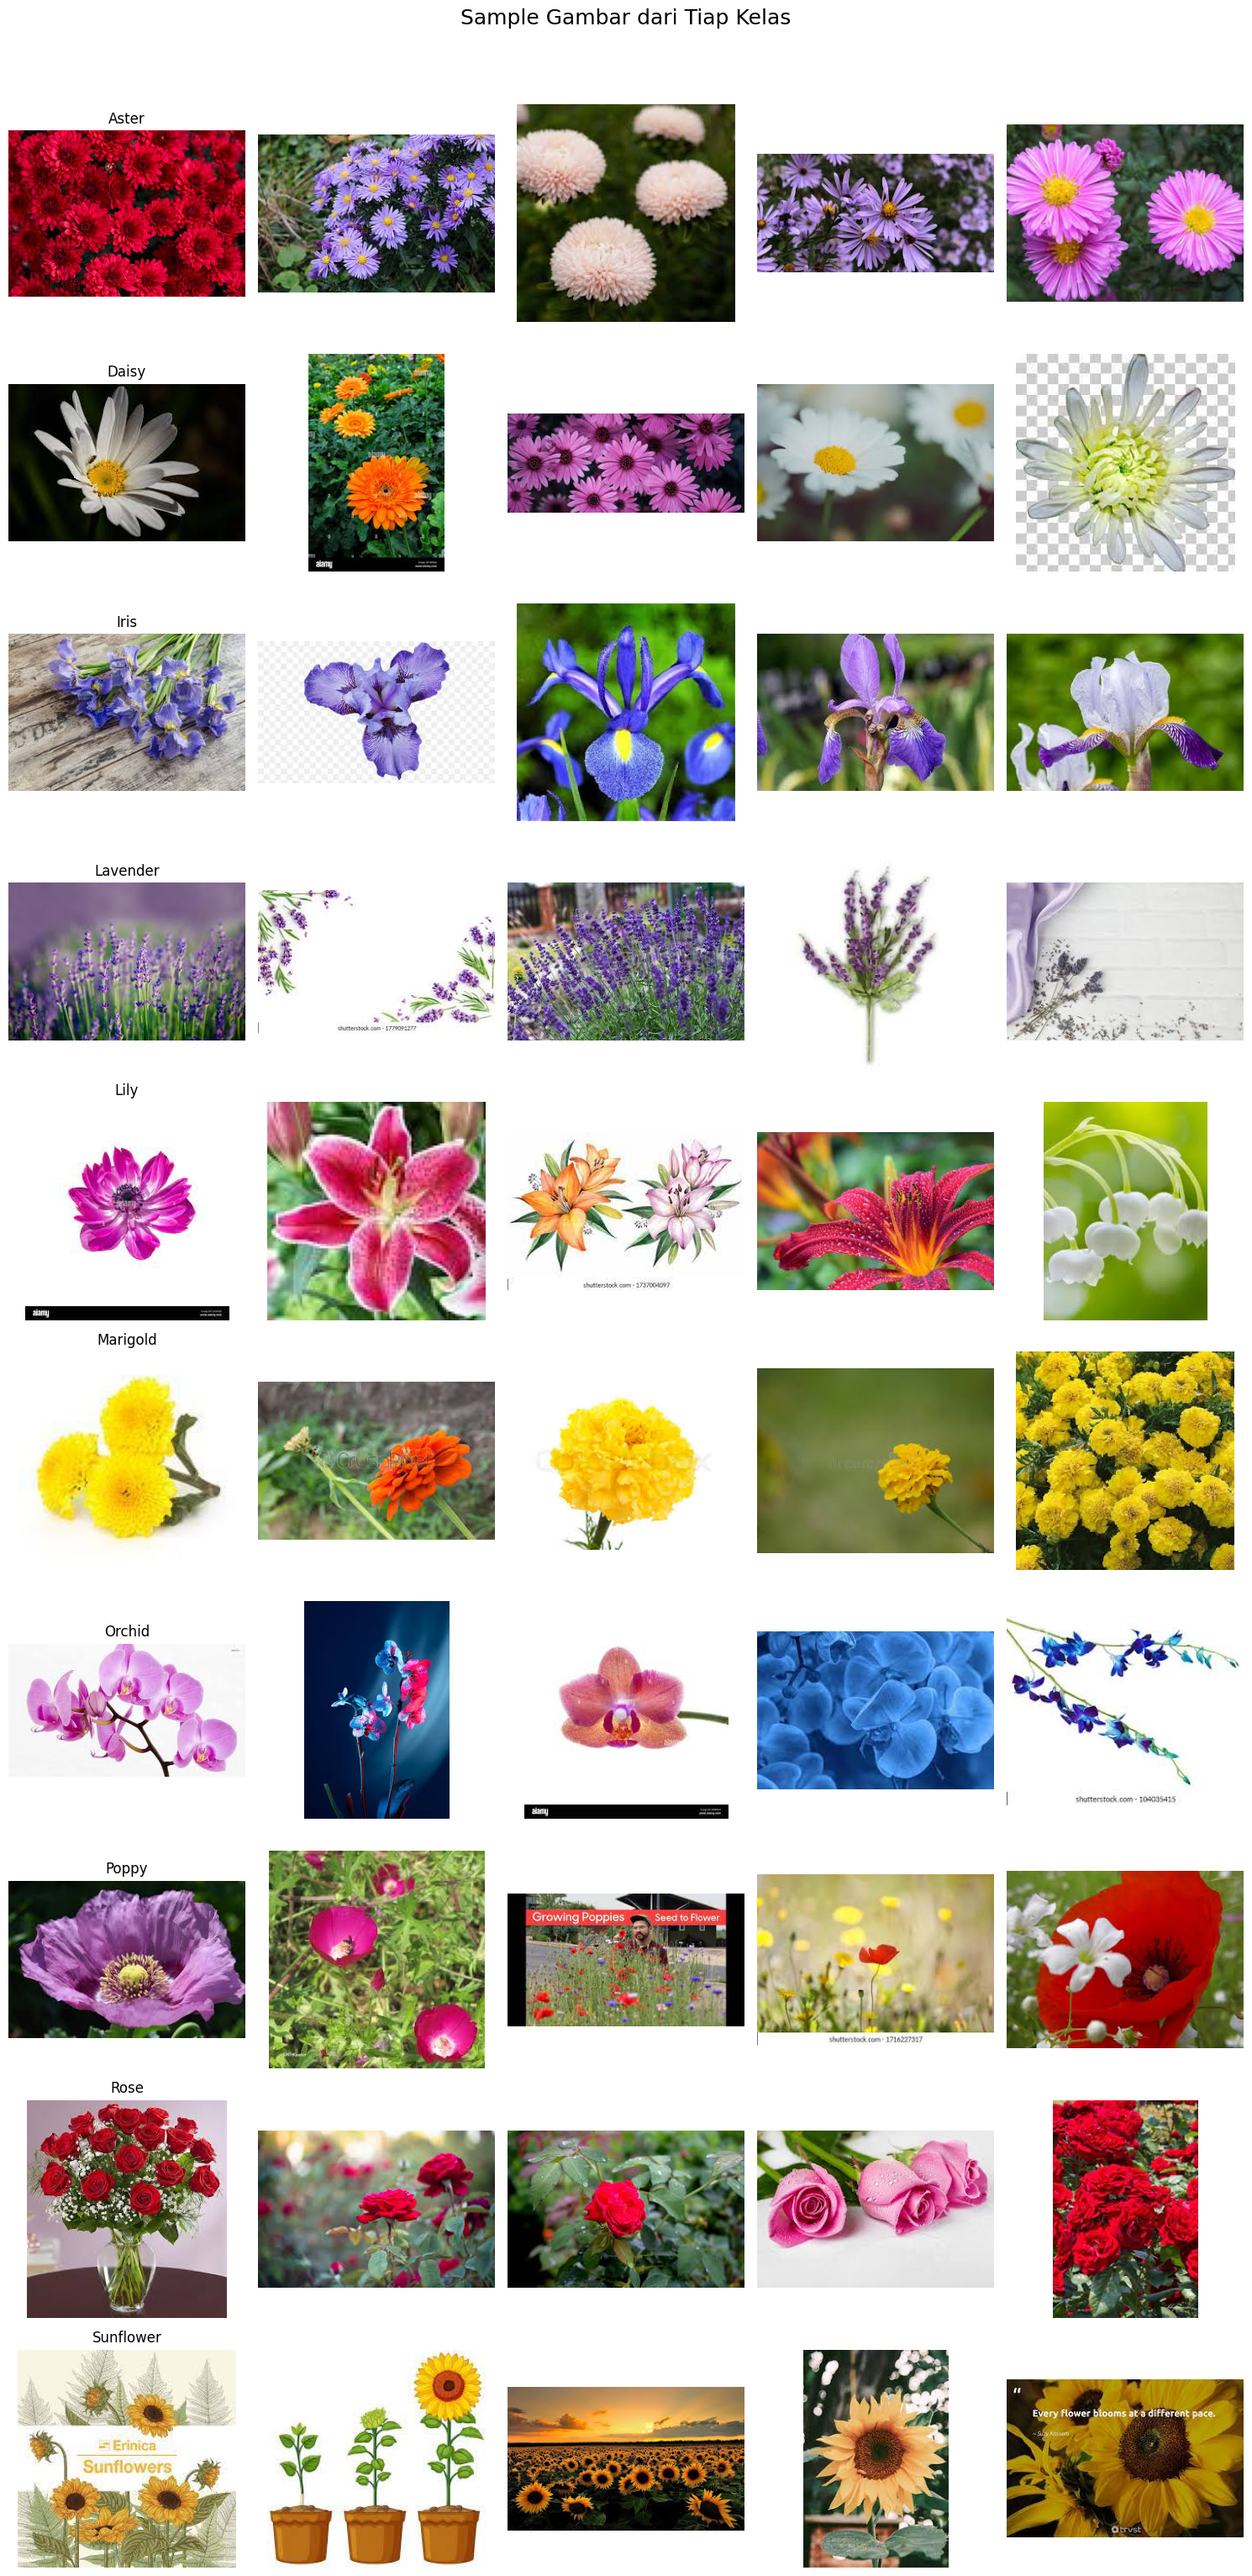

In [11]:
# Tentukan path ke dataset
dataset_path = "/content/flower-classification/combine-dataset"

# Ambil daftar kelas (nama folder)
class_names = sorted([f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))])

# Hitung jumlah kelas
total_classes = len(class_names)

# Buat subplot: baris = jumlah kelas, kolom = 5 gambar per kelas
fig, axs = plt.subplots(total_classes, 5, figsize=(15, total_classes * 3))

# Tambahkan judul utama visualisasi
fig.suptitle("Sample Gambar dari Tiap Kelas", fontsize=18, y=1.02)

# Loop untuk setiap kelas
for i, class_name in enumerate(class_names):
    class_path = os.path.join(dataset_path, class_name)
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

    # Pilih maksimal 5 gambar secara acak dari kelas tersebut
    sample_images = np.random.choice(images, min(5, len(images)), replace=False)

    # Tampilkan gambar ke subplot
    for j, img_name in enumerate(sample_images):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)

        axs[i, j].imshow(img)
        axs[i, j].axis("off")

        # Tampilkan nama kelas hanya di gambar pertama di tiap baris
        if j == 0:
            axs[i, j].set_title(class_name, fontsize=12)

# Tata letak subplot agar tidak saling tumpang tindih
plt.tight_layout()
plt.show()

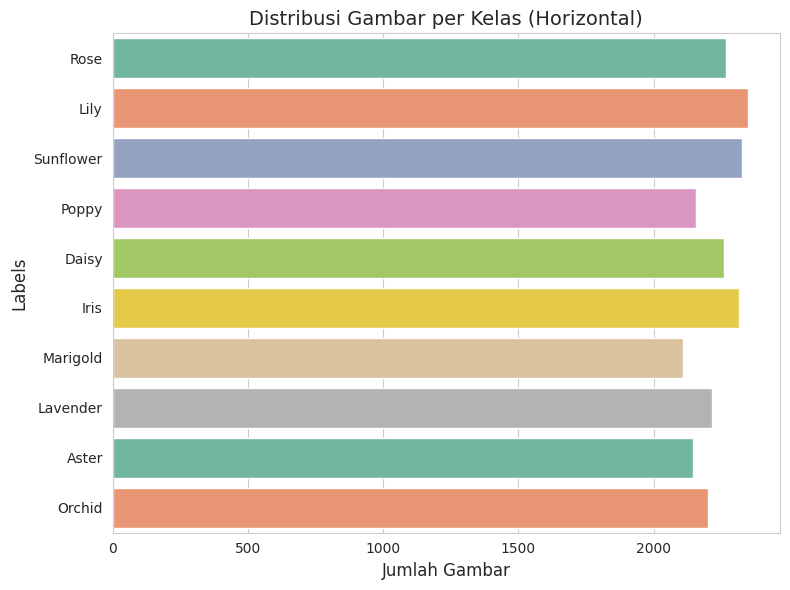

In [12]:
# Path ke dataset
lung_path = "/content/flower-classification/combine-dataset"

# List untuk menyimpan nama file, path lengkap, dan label kelas
file_name = []
labels = []
full_path = []

# Loop untuk ambil data dari tiap file gambar
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])  # Ambil nama folder sebagai label
        file_name.append(name)

# Simpan dalam DataFrame
distribution_train = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

# Plot distribusi gambar berdasarkan kelas secara horizontal
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

# Buat color palette sesuai jumlah kelas unik
num_unique_classes = distribution_train['labels'].nunique()
color_palette = sns.color_palette("Set2", n_colors=num_unique_classes)

# Plot distribusi horizontal dengan hue dan legend False
plot_data = sns.countplot(
    data=distribution_train,
    y='labels',
    palette=color_palette,
    hue='labels',
    legend=False
)

# Tambahkan judul & label sumbu
plt.title("Distribusi Gambar per Kelas (Horizontal)", fontsize=14)
plt.xlabel("Jumlah Gambar", fontsize=12)
plt.ylabel("Labels", fontsize=12)

plt.tight_layout()
plt.show()

In [13]:
# Menampilkan jumlah gambar untuk setiap kelas
print("Jumlah gambar per kelas:\n")
print(distribution_train['labels'].value_counts())
print("\nTotal keseluruhan gambar:", distribution_train.shape[0])

Jumlah gambar per kelas:

labels
Lily         2350
Sunflower    2328
Iris         2317
Rose         2269
Daisy        2260
Lavender     2217
Orchid       2202
Poppy        2158
Aster        2146
Marigold     2108
Name: count, dtype: int64

Total keseluruhan gambar: 22355


In [14]:
# Fungsi untuk menampilkan jumlah gambar dan resolusi unik dari gambar-gambar dalam setiap folder kelas
def print_images_resolution(directory):
    total_images = 0  # Variabel untuk menghitung total seluruh gambar di semua kelas

    # Iterasi setiap folder dalam direktori utama
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)  # Buat path lengkap ke subfolder
        if not os.path.isdir(subdir_path):  # Lewati jika bukan folder
            continue

        image_list = os.listdir(subdir_path)  # Ambil semua file dalam folder
        image_count = len(image_list)  # Hitung jumlah file gambar dalam folder
        print(f"{subdir}: {image_count}")  # Tampilkan nama folder dan jumlah gambar
        total_images += image_count  # Tambahkan ke total keseluruhan

        resolution_set = set()  # Set untuk menyimpan resolusi unik dari gambar-gambar

        # Iterasi setiap gambar dalam folder
        for image_file in image_list:
            image_path = os.path.join(subdir_path, image_file)  # Path lengkap ke file gambar
            try:
                with Image.open(image_path) as img:  # Buka gambar
                    resolution_set.add(img.size)  # Tambahkan resolusinya ke set
            except Exception as error:  # Tangani error jika gambar gagal dibuka
                print(f"Error reading {image_path}: {error}")

        # Tampilkan semua resolusi unik dari folder saat ini
        for size in resolution_set:
            print(f"- {size}")
        print("=====================================================")  # Pembatas antar kelas

    # Tampilkan total semua gambar dari semua kelas
    print(f"\nJumlah gambar keseluruhan: {total_images}")

# Path ke folder dataset
directory_path = "/content/flower-classification/combine-dataset/"

# Cetak informasi resolusi dan jumlah gambar
print('Ukuran resolusi dan jumlah data pada tiap kelas:\n')
print_images_resolution(directory_path)

Ukuran resolusi dan jumlah data pada tiap kelas:

Rose: 2269
- (176, 286)
- (178, 283)
- (179, 282)
- (204, 247)
- (205, 246)
- (206, 244)
- (225, 224)
- (328, 154)
- (190, 266)
- (188, 269)
- (191, 265)
- (170, 297)
- (200, 252)
- (177, 284)
- (201, 251)
- (202, 249)
- (203, 248)
- (221, 229)
- (223, 226)
- (102, 400)
- (186, 271)
- (229, 221)
- (187, 270)
- (168, 299)
- (189, 267)
- (276, 183)
- (239, 211)
- (199, 253)
- (152, 330)
- (254, 198)
- (259, 194)
- (170, 171)
- (185, 272)
- (280, 180)
- (347, 145)
- (266, 190)
- (197, 255)
- (267, 189)
- (175, 289)
- (272, 185)
- (240, 180)
- (257, 196)
- (252, 200)
- (258, 195)
- (287, 176)
- (220, 220)
- (166, 304)
- (213, 236)
- (247, 204)
- (278, 182)
- (279, 181)
- (284, 177)
- (173, 291)
- (270, 187)
- (150, 335)
- (299, 168)
- (172, 280)
- (256, 197)
- (158, 318)
- (164, 306)
- (245, 206)
- (209, 241)
- (163, 308)
- (262, 192)
- (246, 205)
- (251, 201)
- (290, 174)
- (220, 195)
- (291, 173)
- (217, 233)
- (157, 322)
- (269, 188)
- (

### Data Preprocessing

#### Split Dataset

In [15]:
# Path ke folder dataset gambar bunga
dataset_path = '/content/flower-classification/combine-dataset'

# List untuk menyimpan nama file, label, dan path lengkap
file_name = []
labels = []
full_path = []

# Loop untuk mengumpulkan info file gambar
for path, subdirs, files in os.walk(dataset_path):
    for name in files:
        full_path.append(os.path.join(path, name))  # Path lengkap
        labels.append(path.split('/')[-1])          # Nama folder sebagai label
        file_name.append(name)                      # Nama file gambar

# Buat dataframe dari hasil loop
image_df = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

# Lihat jumlah gambar di setiap label
image_df.groupby(['labels']).size()

labels
Aster        2146
Daisy        2260
Iris         2317
Lavender     2217
Lily         2350
Marigold     2108
Orchid       2202
Poppy        2158
Rose         2269
Sunflower    2328
dtype: int64

In [16]:
# Direktori dataset gabungan (combine dataset)
dataset_dir = '/content/flower-classification/combine-dataset'

# Direktori untuk menyimpan dataset yang sudah dibagi menjadi pelatihan, validasi, dan pengujian
output_dir = '/content/flower-classification/splitte-dataset'
os.makedirs(output_dir, exist_ok=True)  # Membuat direktori output jika belum ada

# Persentase pembagian data menjadi training, validation, dan testing
train_ratio = 0.7  # 70% untuk training
val_ratio = 0.15   # 15% untuk validation
test_ratio = 0.15  # 15% untuk testing

# Pastikan total rasio pembagian data adalah 1 (100%)
assert train_ratio + val_ratio + test_ratio == 1

# Daftar semua subdirektori (kelas) yang ada dalam dataset
class_names = os.listdir(dataset_dir)

# Loop untuk setiap kelas (subdirektori)
for cls_name in class_names:
    # Path ke direktori setiap kelas
    class_path = os.path.join(dataset_dir, cls_name)

    # Mendapatkan daftar nama file gambar dalam kelas tersebut
    image_files = os.listdir(class_path)

    # Membagi data menjadi set pelatihan (training) dan set sementara (untuk validasi dan testing)
    train_images, temp_images = train_test_split(image_files, test_size=(1 - train_ratio), random_state=42)

    # Membagi set sementara menjadi set validasi dan pengujian (test)
    val_images, test_images = train_test_split(temp_images, test_size=test_ratio / (val_ratio + test_ratio), random_state=42)

    # Membuat direktori untuk set pelatihan, validasi, dan pengujian untuk setiap kelas
    train_directory = os.path.join(output_dir, 'train', cls_name)
    val_directory = os.path.join(output_dir, 'val', cls_name)
    test_directory = os.path.join(output_dir, 'test', cls_name)
    os.makedirs(train_directory, exist_ok=True)
    os.makedirs(val_directory, exist_ok=True)
    os.makedirs(test_directory, exist_ok=True)

    # Menyalin gambar dari set pelatihan ke direktori pelatihan
    for img in train_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(train_directory, img)
        shutil.copyfile(src, dst)

    # Menyalin gambar dari set validasi ke direktori validasi
    for img in val_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(val_directory, img)
        shutil.copyfile(src, dst)

    # Menyalin gambar dari set pengujian ke direktori pengujian
    for img in test_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(test_directory, img)
        shutil.copyfile(src, dst)

# Output pesan setelah pembagian selesai
print("Dataset berhasil dibagi menjadi tiga set: training, validation, dan testing!")
print(f"Rasio pembagian: {train_ratio*100}% untuk training, {val_ratio*100}% untuk validation, dan {test_ratio*100}% untuk testing.")


Dataset berhasil dibagi menjadi tiga set: training, validation, dan testing!
Rasio pembagian: 70.0% untuk training, 15.0% untuk validation, dan 15.0% untuk testing.


## Modelling

In [17]:
# Inisialisasi parameter
image_dimension = 224  # Ukuran gambar input untuk MobileNetV2
batch_capacity = 32
epochs = 50

# Direktori dataset
train_directory = '/content/flower-classification/splitte-dataset/train'
val_directory = '/content/flower-classification/splitte-dataset/val'
test_directory = '/content/flower-classification/splitte-dataset/test'

# Data augmentation untuk data pelatihan (lebih ringan)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=[0.9, 1.1],
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Data augmentation untuk validasi & pengujian (hanya normalisasi)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Membaca gambar untuk training set
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(image_dimension, image_dimension),
    batch_size=batch_capacity,
    class_mode='categorical'
)

# Membaca gambar untuk validation set
val_generator = val_datagen.flow_from_directory(
    val_directory,
    target_size=(image_dimension, image_dimension),
    batch_size=batch_capacity,
    class_mode='categorical'
)

# Membaca gambar untuk test set
test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(image_dimension, image_dimension),
    batch_size=batch_capacity,
    class_mode='categorical'
)


Found 15642 images belonging to 10 classes.
Found 3354 images belonging to 10 classes.
Found 3359 images belonging to 10 classes.


In [18]:
# Parameter gambar
image_dimension = 224  # Ukuran input gambar sesuai MobileNetV2

# Direktori train
train_directory = "/content/flower-classification/splitte-dataset/train"

# Hitung jumlah kelas berdasarkan jumlah folder
cnt_classes = len([d for d in os.listdir(train_directory) if os.path.isdir(os.path.join(train_directory, d))])

# Learning rate schedule
initial_learning_rate = 0.0005
lr_schedule = ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.8, staircase=True
)

# Load MobileNetV2 sebagai feature extractor
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_dimension, image_dimension, 3))
base_model.trainable = True  # Unfreeze beberapa layer terakhir

# Fine-tune hanya layer terakhir dari MobileNetV2
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Buat model
model = Sequential([
    base_model,
    Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    GlobalAveragePooling2D(),
    BatchNormalization(),

    Dense(256, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001)),
    Dropout(0.4),

    Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001)),
    Dropout(0.4),

    Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001)),
    Dropout(0.3),

    Dense(cnt_classes, activation='softmax')
])

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Lihat struktur model
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 256)      │     2,949,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,579,274 (21.28 MB)

 Trainable params: 4,846,666 (18.49 MB)

 Non-trainable params: 732,608 (2.79 MB)

In [19]:
# Callback untuk stop training saat akurasi training & validasi sama-sama ≥ 95%
class StopTrainingAtAccuracy(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        train_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')

        if train_acc is not None and val_acc is not None:
            if train_acc >= 0.95 and val_acc >= 0.95:
                print(f"\nEpoch {epoch+1}: Mantap! Akurasi training ({train_acc:.2%}) & validasi ({val_acc:.2%}) sudah di atas 95%. Training dihentikan")
                self.model.stop_training = True

# Callback untuk simpan model terbaik (berdasarkan val_accuracy tertinggi)
checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Jalankan training dengan callback
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[checkpoint, StopTrainingAtAccuracy()]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.3304 - loss: 2.2983
Epoch 1: val_accuracy improved from -inf to 0.71288, saving model to best_model.h5


489/489 ━━━━━━━━━━━━━━━━━━━━ 262s 485ms/step - accuracy: 0.3308 - loss: 2.2971 - val_accuracy: 0.7129 - val_loss: 1.1197
Epoch 2/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.7213 - loss: 1.0590
Epoch 2: val_accuracy improved from 0.71288 to 0.75790, saving model to best_model.h5


489/489 ━━━━━━━━━━━━━━━━━━━━ 217s 444ms/step - accuracy: 0.7213 - loss: 1.0589 - val_accuracy: 0.7579 - val_loss: 1.0643
Epoch 3/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.7867 - loss: 0.8611
Epoch 3: val_accuracy improved from 0.75790 to 0.77788, saving model to best_model.h5


489/489 ━━━━━━━━━━━━━━━━━━━━ 259s 438ms/step - accuracy: 0.7867 - loss: 0.8611 - val_accuracy: 0.7779 - val_loss: 0.9357
Epoch 4/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.8311 - loss: 0.7306
Epoch 4: val_accuracy improved from 0.77788 to 0.82081, saving model to best_model.h5


489/489 ━━━━━━━━━━━━━━━━━━━━ 220s 449ms/step - accuracy: 0.8311 - loss: 0.7306 - val_accuracy: 0.8208 - val_loss: 0.7834
Epoch 5/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.8379 - loss: 0.6845
Epoch 5: val_accuracy did not improve from 0.82081
489/489 ━━━━━━━━━━━━━━━━━━━━ 220s 450ms/step - accuracy: 0.8379 - loss: 0.6845 - val_accuracy: 0.8128 - val_loss: 0.7846
Epoch 6/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.8651 - loss: 0.6090
Epoch 6: val_accuracy improved from 0.82081 to 0.83363, saving model to best_model.h5


489/489 ━━━━━━━━━━━━━━━━━━━━ 216s 441ms/step - accuracy: 0.8651 - loss: 0.6090 - val_accuracy: 0.8336 - val_loss: 0.8239
Epoch 7/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.8652 - loss: 0.5815
Epoch 7: val_accuracy did not improve from 0.83363
489/489 ━━━━━━━━━━━━━━━━━━━━ 217s 444ms/step - accuracy: 0.8652 - loss: 0.5815 - val_accuracy: 0.8143 - val_loss: 0.9098
Epoch 8/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.8817 - loss: 0.5370
Epoch 8: val_accuracy did not improve from 0.83363
489/489 ━━━━━━━━━━━━━━━━━━━━ 214s 437ms/step - accuracy: 0.8817 - loss: 0.5370 - val_accuracy: 0.8110 - val_loss: 1.0340
Epoch 9/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.8914 - loss: 0.4864
Epoch 9: val_accuracy improved from 0.83363 to 0.83989, saving model to best_model.h5


489/489 ━━━━━━━━━━━━━━━━━━━━ 220s 451ms/step - accuracy: 0.8914 - loss: 0.4865 - val_accuracy: 0.8399 - val_loss: 0.7462
Epoch 10/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.8890 - loss: 0.4972
Epoch 10: val_accuracy did not improve from 0.83989
489/489 ━━━━━━━━━━━━━━━━━━━━ 213s 436ms/step - accuracy: 0.8890 - loss: 0.4972 - val_accuracy: 0.8035 - val_loss: 0.9163
Epoch 11/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.9005 - loss: 0.4520
Epoch 11: val_accuracy did not improve from 0.83989
489/489 ━━━━━━━━━━━━━━━━━━━━ 219s 447ms/step - accuracy: 0.9004 - loss: 0.4520 - val_accuracy: 0.8166 - val_loss: 0.9264
Epoch 12/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.9038 - loss: 0.4388
Epoch 12: val_accuracy did not improve from 0.83989
489/489 ━━━━━━━━━━━━━━━━━━━━ 213s 436ms/step - accuracy: 0.9038 - loss: 0.4388 - val_accuracy: 0.8393 - val_loss: 0.7798
Epoch 13/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9100 - loss: 0.4106
Epoc

489/489 ━━━━━━━━━━━━━━━━━━━━ 215s 440ms/step - accuracy: 0.9100 - loss: 0.4106 - val_accuracy: 0.8426 - val_loss: 0.8050
Epoch 14/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.9167 - loss: 0.3899
Epoch 14: val_accuracy did not improve from 0.84258
489/489 ━━━━━━━━━━━━━━━━━━━━ 214s 438ms/step - accuracy: 0.9167 - loss: 0.3899 - val_accuracy: 0.8241 - val_loss: 0.8460
Epoch 15/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9213 - loss: 0.3692
Epoch 15: val_accuracy did not improve from 0.84258
489/489 ━━━━━━━━━━━━━━━━━━━━ 214s 438ms/step - accuracy: 0.9213 - loss: 0.3692 - val_accuracy: 0.8339 - val_loss: 0.9093
Epoch 16/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.9254 - loss: 0.3406
Epoch 16: val_accuracy improved from 0.84258 to 0.85301, saving model to best_model.h5


489/489 ━━━━━━━━━━━━━━━━━━━━ 213s 436ms/step - accuracy: 0.9254 - loss: 0.3406 - val_accuracy: 0.8530 - val_loss: 0.7745
Epoch 17/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.9351 - loss: 0.3158
Epoch 17: val_accuracy improved from 0.85301 to 0.85450, saving model to best_model.h5


489/489 ━━━━━━━━━━━━━━━━━━━━ 221s 451ms/step - accuracy: 0.9351 - loss: 0.3158 - val_accuracy: 0.8545 - val_loss: 0.8661
Epoch 18/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.9344 - loss: 0.3163
Epoch 18: val_accuracy did not improve from 0.85450
489/489 ━━━━━━━━━━━━━━━━━━━━ 256s 440ms/step - accuracy: 0.9344 - loss: 0.3163 - val_accuracy: 0.8354 - val_loss: 0.9485
Epoch 19/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.9356 - loss: 0.3081
Epoch 19: val_accuracy did not improve from 0.85450
489/489 ━━━━━━━━━━━━━━━━━━━━ 213s 436ms/step - accuracy: 0.9355 - loss: 0.3081 - val_accuracy: 0.8396 - val_loss: 0.8680
Epoch 20/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.9390 - loss: 0.2919
Epoch 20: val_accuracy did not improve from 0.85450
489/489 ━━━━━━━━━━━━━━━━━━━━ 262s 437ms/step - accuracy: 0.9390 - loss: 0.2920 - val_accuracy: 0.8309 - val_loss: 0.8991
Epoch 21/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.9446 - loss: 0.2680
Epoc

489/489 ━━━━━━━━━━━━━━━━━━━━ 214s 438ms/step - accuracy: 0.9445 - loss: 0.2680 - val_accuracy: 0.8682 - val_loss: 0.6605
Epoch 22/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.9498 - loss: 0.2481
Epoch 22: val_accuracy improved from 0.86822 to 0.87597, saving model to best_model.h5


489/489 ━━━━━━━━━━━━━━━━━━━━ 263s 439ms/step - accuracy: 0.9498 - loss: 0.2482 - val_accuracy: 0.8760 - val_loss: 0.7177
Epoch 23/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.9566 - loss: 0.2201
Epoch 23: val_accuracy did not improve from 0.87597
489/489 ━━━━━━━━━━━━━━━━━━━━ 216s 441ms/step - accuracy: 0.9566 - loss: 0.2202 - val_accuracy: 0.8494 - val_loss: 0.8323
Epoch 24/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.9577 - loss: 0.2104
Epoch 24: val_accuracy did not improve from 0.87597
489/489 ━━━━━━━━━━━━━━━━━━━━ 216s 442ms/step - accuracy: 0.9577 - loss: 0.2105 - val_accuracy: 0.8542 - val_loss: 0.8152
Epoch 25/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.9645 - loss: 0.1848
Epoch 25: val_accuracy did not improve from 0.87597
489/489 ━━━━━━━━━━━━━━━━━━━━ 217s 443ms/step - accuracy: 0.9645 - loss: 0.1848 - val_accuracy: 0.8548 - val_loss: 0.7219
Epoch 26/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9639 - loss: 0.1927
Epoc

489/489 ━━━━━━━━━━━━━━━━━━━━ 213s 436ms/step - accuracy: 0.9695 - loss: 0.1606 - val_accuracy: 0.8769 - val_loss: 0.6912
Epoch 32/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9714 - loss: 0.1486
Epoch 32: val_accuracy did not improve from 0.87686
489/489 ━━━━━━━━━━━━━━━━━━━━ 217s 443ms/step - accuracy: 0.9713 - loss: 0.1486 - val_accuracy: 0.8617 - val_loss: 0.7911
Epoch 33/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.9691 - loss: 0.1547
Epoch 33: val_accuracy did not improve from 0.87686
489/489 ━━━━━━━━━━━━━━━━━━━━ 213s 436ms/step - accuracy: 0.9691 - loss: 0.1547 - val_accuracy: 0.8691 - val_loss: 0.7752
Epoch 34/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.9696 - loss: 0.1642
Epoch 34: val_accuracy did not improve from 0.87686
489/489 ━━━━━━━━━━━━━━━━━━━━ 213s 434ms/step - accuracy: 0.9696 - loss: 0.1642 - val_accuracy: 0.8694 - val_loss: 0.8412
Epoch 35/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.9709 - loss: 0.1510
Epoc

489/489 ━━━━━━━━━━━━━━━━━━━━ 222s 454ms/step - accuracy: 0.9813 - loss: 0.1016 - val_accuracy: 0.8778 - val_loss: 0.7797
Epoch 46/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.9809 - loss: 0.1020
Epoch 46: val_accuracy did not improve from 0.87776
489/489 ━━━━━━━━━━━━━━━━━━━━ 218s 445ms/step - accuracy: 0.9809 - loss: 0.1020 - val_accuracy: 0.8742 - val_loss: 0.8247
Epoch 47/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9825 - loss: 0.1059
Epoch 47: val_accuracy did not improve from 0.87776
489/489 ━━━━━━━━━━━━━━━━━━━━ 214s 437ms/step - accuracy: 0.9825 - loss: 0.1059 - val_accuracy: 0.8697 - val_loss: 0.8014
Epoch 48/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.9865 - loss: 0.0774
Epoch 48: val_accuracy did not improve from 0.87776
489/489 ━━━━━━━━━━━━━━━━━━━━ 219s 448ms/step - accuracy: 0.9864 - loss: 0.0774 - val_accuracy: 0.8706 - val_loss: 0.7970
Epoch 49/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.9801 - loss: 0.1037
Epoc

## Evaluasi dan Visualisasi

In [27]:
# Direktori test
test_directory = "/content/flower-classification/splitte-dataset/test"

# Preprocessing: hanya rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Load test dataset
test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(image_dimension, image_dimension),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Jangan diacak
)

# Evaluasi model
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"\nModel berhasil mengklasifikasikan data test dengan akurasi sebesar {test_accuracy * 100:.2f}%")


Found 3359 images belonging to 10 classes.
105/105 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - accuracy: 0.8561 - loss: 0.9103

Model berhasil mengklasifikasikan data test dengan akurasi sebesar 88.78%


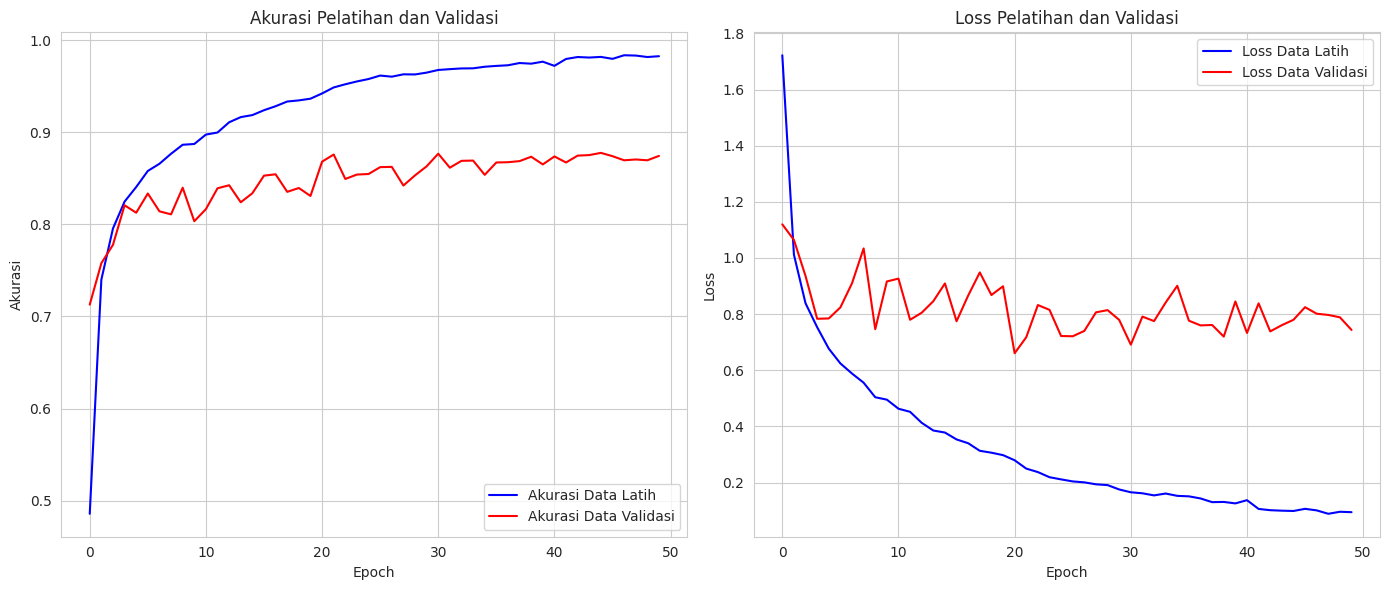

In [28]:
plt.figure(figsize=(14, 6))

# --- Plot Akurasi ---
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Data Latih', color='blue')
plt.plot(history.history['val_accuracy'], label='Akurasi Data Validasi', color='red')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.title('Akurasi Pelatihan dan Validasi')
plt.legend(loc='lower right')
plt.grid(True)

# --- Plot Loss ---
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Data Latih', color='blue')
plt.plot(history.history['val_loss'], label='Loss Data Validasi', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Pelatihan dan Validasi')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

105/105 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step


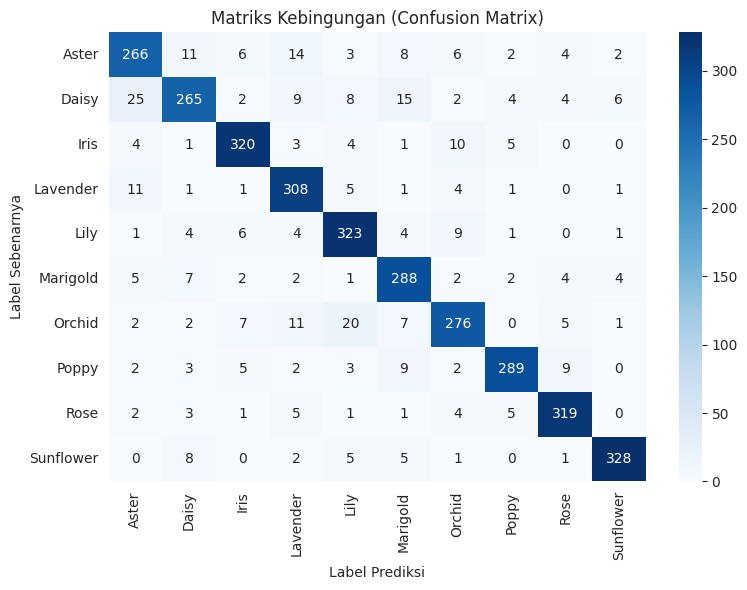


Laporan Klasifikasi:
              precision    recall  f1-score   support

       Aster       0.84      0.83      0.83       322
       Daisy       0.87      0.78      0.82       340
        Iris       0.91      0.92      0.92       348
    Lavender       0.86      0.92      0.89       333
        Lily       0.87      0.92      0.89       353
    Marigold       0.85      0.91      0.88       317
      Orchid       0.87      0.83      0.85       331
       Poppy       0.94      0.89      0.91       324
        Rose       0.92      0.94      0.93       341
   Sunflower       0.96      0.94      0.95       350

    accuracy                           0.89      3359
   macro avg       0.89      0.89      0.89      3359
weighted avg       0.89      0.89      0.89      3359



In [29]:
# Melakukan prediksi pada dataset uji
Y_pred = model.predict(test_generator)
Y_pred_classes = np.argmax(Y_pred, axis=1)  # Konversi dari probabilitas ke label kelas

# Ambil label asli dari dataset uji
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Daftar nama kelas

# Buat Confusion Matrix
confusion_matrix = confusion_matrix(true_classes, Y_pred_classes)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d",
            xticklabels=class_labels,
            yticklabels=class_labels,
            cmap="Blues")
plt.xlabel('Label Prediksi')
plt.ylabel('Label Sebenarnya')
plt.title('Matriks Kebingungan (Confusion Matrix)')
plt.tight_layout()
plt.show()

# Tampilkan laporan klasifikasi lengkap
print("\nLaporan Klasifikasi:")
print(classification_report(true_classes, Y_pred_classes, target_names=class_labels))

## Konversi Model

In [30]:
# Menentukan path untuk penyimpanan model
save_path = 'saved_model/'

# Membuat folder apabila belum ada
os.makedirs(save_path, exist_ok=True)

# Menyimpan model dalam format SavedModel
try:
    tf.saved_model.save(model, save_path)
    print(f'Berhasil menyimpan Model SavedModel di {os.path.abspath(save_path)}')
except Exception as e:
    print(f'Gagal menyimpan model: {e}')

Berhasil menyimpan Model SavedModel di /content/saved_model


In [31]:
# Tentukan path penyimpanan model TFLite
tflite_target_direct = "tflite/"
os.makedirs(tflite_target_direct, exist_ok=True)
tflite_model_path = os.path.join(tflite_target_direct, "model.tflite")

try:
    # Mengonversi model SavedModel ke format TFLite
    converter_model = tf.lite.TFLiteConverter.from_saved_model(save_path)
    tflite_model = converter_model.convert()

    # Menyimpan model TFLite ke dalam file
    with tf.io.gfile.GFile(tflite_model_path, 'wb') as f:
        f.write(tflite_model)

    print(f'Berhasil menyimpan Model TFLite berhasil di {os.path.abspath(tflite_model_path)}')

except Exception as e:
    print(f'Gagal mengonversi atau menyimpan model TFLite: {e}')

Berhasil menyimpan Model TFLite berhasil di /content/tflite/model.tflite


In [32]:
# Tentukan direktori tujuan untuk menyimpan model dalam format TensorFlow.js
tfjs_target_dir = "tfjs_model"
os.makedirs(tfjs_target_dir, exist_ok=True)

try:
    # Mengonversi model SavedModel ke format TensorFlow.js
    tfjs.converters.convert_tf_saved_model(save_path, tfjs_target_dir)

    # Menampilkan lokasi folder tempat model disimpan
    print(f'Berhasil menyimpan model TensorFlow.js di {os.path.abspath(tfjs_target_dir)}')

except Exception as e:
    # Menangani jika terjadi kesalahan selama konversi atau penyimpanan model
    print(f'Gagal mengonversi model ke TensorFlow.js: {e}')

Berhasil menyimpan model TensorFlow.js di /content/tfjs_model


In [35]:
import shutil
from google.colab import files

# Melakukan compress folder menjadi zip
shutil.make_archive('/content/tflite', 'zip', '/content/tflite')
shutil.make_archive('/content/saved_model', 'zip', '/content/saved_model')
shutil.make_archive('/content/tfjs_model', 'zip', '/content/tfjs_model')

# Mengunduh file zip untuk disimpan ke lokal
files.download('/content/tflite.zip')
files.download('/content/saved_model.zip')
files.download('/content/tfjs_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)

Saving dummy.jpeg to dummy.jpeg
Prediction completed successfully.
Image uploaded: dummy.jpeg
Predicted class: 8 (Rose)


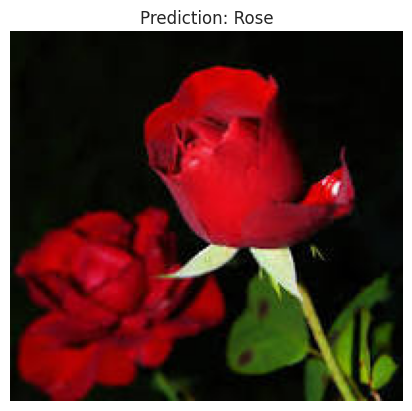

In [36]:
# Mengunggah file gambar dari komputer user/lokal
upload = files.upload()
image_path = list(upload.keys())[0]

# Menentukan path ke direktori model SavedModel
saved_model_path = '/content/saved_model'

# Memuat model dari format SavedModel
model = tf.saved_model.load(saved_model_path)

# Mengakses fungsi inference dari signature default model
infer = model.signatures["serving_default"]

# Pemetaan indeks kelas ke nama-nama bunga
label_map = {
    0: "Aster",
    1: "Daisy",
    2: "Iris",
    3: "Lavender",
    4: "Lily",
    5: "Marigold",
    6: "Orchid",
    7: "Poppy",
    8: "Rose",
    9: "Sunflower"
}

# Fungsi untuk memuat dan mempersiapkan gambar sebelum dilakukan prediksi
def prepare_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)  # Resize gambar ke ukuran target
    img_array = image.img_to_array(img)                      # Ubah gambar ke array NumPy
    img_array = np.expand_dims(img_array, axis=0)            # Tambahkan dimensi batch
    img_array = img_array / 255.0                            # Normalisasi piksel jika diperlukan
    return img_array

# Persiapan gambar yang diunggah
img_array = prepare_image(image_path)

# Melakukan prediksi (inference) menggunakan model
input_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
predictions = infer(input_tensor)

# Mengambil hasil prediksi dari output tensor
output_name = list(predictions.keys())[0]
output_data = predictions[output_name]

# Menentukan kelas dengan probabilitas tertinggi
predicted_class = np.argmax(output_data)

# Mengambil label nama bunga berdasarkan hasil prediksi
predicted_label = label_map.get(predicted_class, "Unknown")

# Menampilkan hasil prediksi di terminal
print("Prediction completed successfully.")
print(f"Image uploaded: {image_path}")
print(f"Predicted class: {predicted_class} ({predicted_label})")

# Menampilkan gambar yang telah diprediksi dengan label hasil prediksi
img = image.load_img(image_path)
plt.imshow(img)
plt.axis("off")
plt.title(f"Prediction: {predicted_label}")
plt.show()